# Audio Speech Commands Recognition

* Data Repository: https://upatrasgr-my.sharepoint.com/:u:/g/personal/ceid3565_upatras_gr/EcUKreKCY0tHvjjfma33pkwBTU522U-WKjrRaJgnQ_ghLg?e=2w6Bdd
* The tutorial is based on: https://www.tensorflow.org/tutorials/audio/simple_audio

In [1]:
# Loads the autoreload extension in Notebook
%load_ext autoreload
# Sets the autoreload mode to reload all modules before executing code
%autoreload 2

#### Imports
Disable warnings

In [2]:
import os
# disable TF debug warnings and numpy import
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import yaml
from datetime import datetime
import time

import numpy as np
import tensorflow as tf

import IPython.display as ipd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Disable Warnings for scikit-learn
def warn(*args, **kwargs):
    """Eliminating warnings from scikit-learn.

    """
    pass
import warnings
warnings.warn = warn

In [3]:
now = datetime.now()
print("date and time of NB execution =", now.strftime("%d/%m/%Y %H:%M:%S"))
start_time = time.time()

date and time of NB execution = 10/12/2023 14:05:27


## Load configuration file and dataset path

Append Parent Directory

In [4]:
import sys; sys.path.append('..')

Import Configuration Module 

In [5]:
from utils import load_config

Load configuration file

In [6]:
config = load_config("../config.yml")

In [7]:
# define variables for data path and sample rate
DATASET_PATH = config["TRAINING_DATA_PATH"]
SAMPLE_RATE = 16000

## Load data 
The audio clips are approximately 1 second at 16kHz.

In [8]:
from crossai.loader import audio_loader

# All signals are resampled at `SAMPLE_RATE` and normalised (0, 1)
df = audio_loader(path=DATASET_PATH, sr=SAMPLE_RATE)

Loaded data into the dataframe: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]                                                   


Create a crossai audio object which will be used for the exploitation of the data processing pipeline.

`cai_audio.data` holds the data in a dataframe: each row/signal is `np.float32`  
and `cai_audio.lalbels` holds the data labels in a dataframe

In [9]:
from crossai.pipelines.audio import Audio

cai_audio = Audio(df)
cai_audio.data.head()

0    [0.506821, 0.50676304, 0.50670505, 0.5071688, ...
1    [0.53376144, 0.5336966, 0.5336966, 0.5336966, ...
2    [0.6036141, 0.6044156, 0.6044885, 0.6037598, 0...
3    [0.4621682, 0.45547011, 0.4510047, 0.44058546,...
4    [0.5535465, 0.5521018, 0.55163574, 0.5524979, ...
Name: data, dtype: object

#### Show audio commands

In [10]:
np.unique(cai_audio.labels)

array(['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes'],
      dtype=object)

## Plot audio waveforms as an example

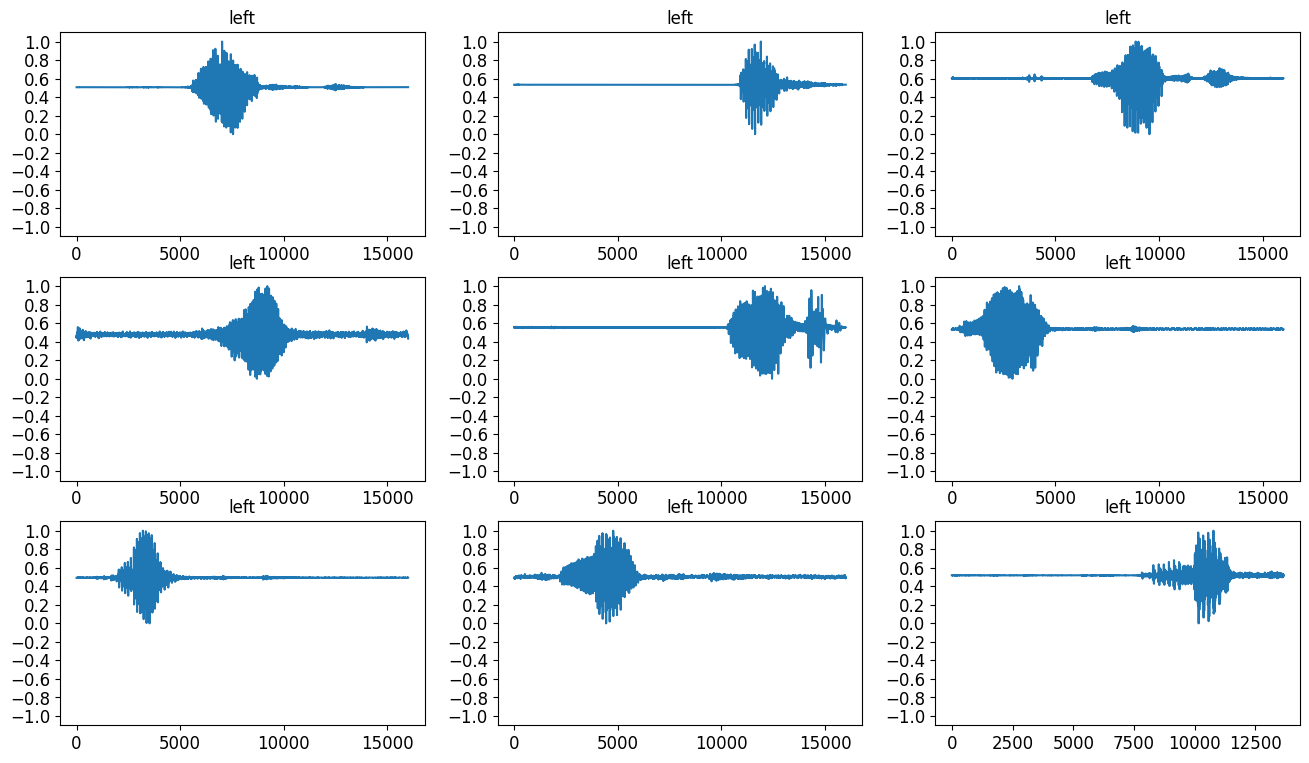

In [11]:
# Number (rows*cols) of waveforms to plot
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(cai_audio.data[i])
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = cai_audio.labels[i]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

## Convert waveforms to spectrograms

A Fourier transform converts a signal to its component frequencies, but loses all time information. In comparison, STFT splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

* The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second.
* When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square.
* The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [12]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Start exploring the data.  
Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio

In [15]:
n = 3
for i in range(n):
  label = cai_audio.labels[i]
  waveform = cai_audio.data[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  ipd.display(ipd.Audio(waveform, rate=SAMPLE_RATE))

Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Define a function for displaying a spectrogram

In [16]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time)

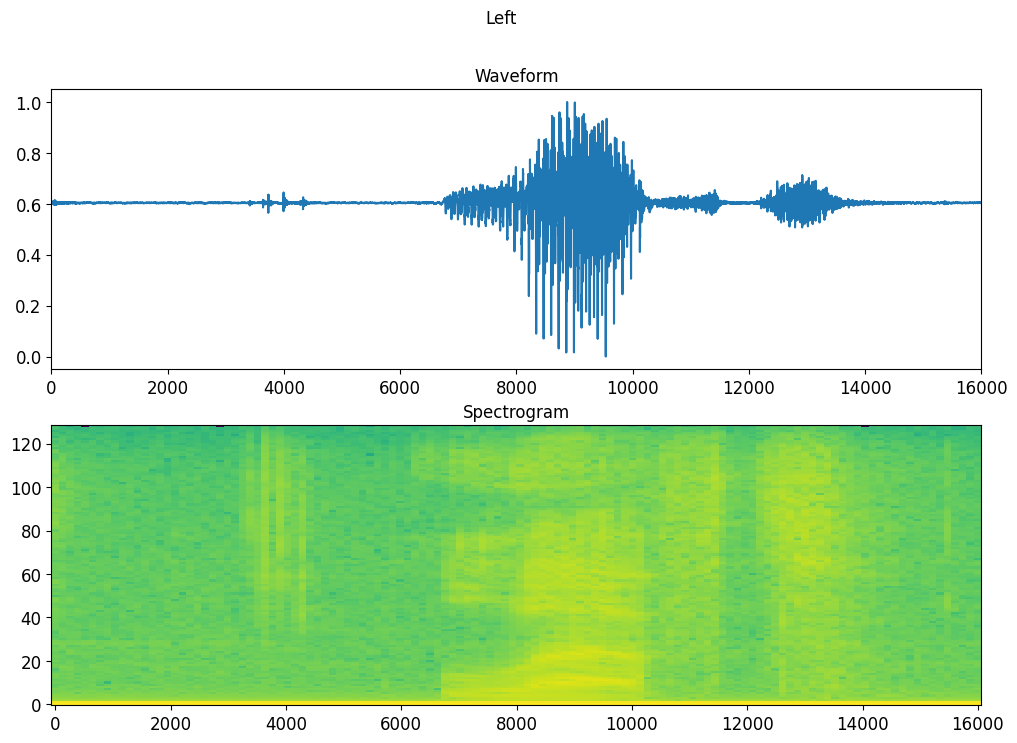

In [17]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform)
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram, axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()